## Imports, Mounts & Utils

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os
import PIL
import psutil
import time
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = "/content/drive/MyDrive/Brain Tumor Classifcation.zip"

extract_path = "/content/"
# Extract the zip file
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify the extraction
os.listdir(extract_path)

['.config', 'drive', 'Brain Tumor Classifcation', 'sample_data']

In [ ]:
dataset_dir ="/content/Brain Tumor Classifcation"
train_dir = "/content/Brain Tumor Classifcation/train"
test_dir = "/content/Brain Tumor Classifcation/test"

In [ ]:
# Function to track CPU memory usage during training
def get_memory_usage():
    return psutil.virtual_memory().percent

# 1. Part A: Implementing Convolutional Neural Network from scratch.

## **1.1 Data Understanding, Analysis, Visualization and Cleaning:**

**1. What does the dataset represent? Provide a brief description.**
> The dataset represents a collection of MRI scans of the human brain. It is organized into different folders, each labeled based on the type of brain condition

**2. How many total images are in the dataset?**

In [ ]:
import os
import matplotlib.pyplot as plt

def count_images(folder_path):
    total = 0
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):
            total += len(os.listdir(class_path))
    return total

# Count images
train_total = count_images(train_dir)
test_total = count_images(test_dir)

# Print totals
print("Train Images:", train_total)
print("Test Images:", test_total)
print("Total Images:", train_total + test_total)

Train Images: 2475
Test Images: 621
Total Images: 3096


> There are 3096 total images in the dataset

**3. What is the distribution of images across different classes?**

In [ ]:
total_class_counts = {}

for subset in ['train', 'test']:
    subset_path = os.path.join(dataset_dir, subset)
    if not os.path.exists(subset_path):
        continue

    class_names = sorted(os.listdir(subset_path))
    for class_name in class_names:
        class_path = os.path.join(subset_path, class_name)
        if os.path.isdir(class_path):
            images = [img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
            if class_name not in total_class_counts:
                total_class_counts[class_name] = 0
            total_class_counts[class_name] += len(images)

print("\nClass Distribution Across Entire Dataset:")
print("=" * 45)
print(f"{'Class Name':<25}{'Total Image Count':>15}")
print("=" * 45)
for class_name, count in total_class_counts.items():
    print(f"{class_name:<25}{count:>15}")
print("=" * 45)



Class Distribution Across Entire Dataset:
Class Name               Total Image Count
glioma_tumor                         901
meningioma_tumor                     913
normal                               438
pituitary_tumor                      844


> The distribution of classes is balanced for all the classes but for the class 'normal'.

> Upon training, the normal class did not appear as an issue to the training of the module due to the Precision, Recall, and F1 Score of the normal class.

**4. How is the dataset split into training and validation sets? Justify your choice.**
>The dataset is structured into two folders:

> 1. Training
2. Testing

>Since there is no dedicated validation folder in the dataset, the training set is split using an 90-10 ratio, where 90% is used for training and 10% for validation.

> This 90-10 split is a commonly used practice in deep learning, as it provides a reasonable balance between model training and performance evaluation especially when the dataset is relatively small.

**5. What preprocessing techniques (e.g., resizing, normalization) were applied?**
> The following preprocessing techniques were applied:
* Data Cleaning:
>>To remove corrupted images
* Resizing:
>>To resize all images into the same shape as CNNs are designed to process images of a specific size

**6. What data generators, if any, were used for preprocessing and augmentation?**

> No data generators were used. However, to generate the train_ds and val_ds from the dataset into the model as a training and testing dataset, a familier method or tool was used called `image_dataset_from_directory	`

**7. If data augmentation was applied, provide visualizations of sample augmented images.**

Data augmentation was not applied because the dataset has limited core variety. Since the dataset is small, augmenting it would only produce altered versions of the same few samples. This can lead the model to memorize repetitive patterns rather than learning diverse and meaningful features, potentially increasing the risk of overfitting.

### **1.1.1 Data Understanding**

In [ ]:
# Get class names (subdirectories)
if not class_names:
  print("No class directories found in the train folder!")
else:
  print(f"Found {len(class_names)} classes: {class_names}")

Found 4 classes: ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']


In [ ]:
# Get the unique extentions of the images
def get_unique_image_formats(folder_path):
    formats = set()
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                file_ext = os.path.splitext(file_name)[1].lower()  # Get extension in lowercase
                formats.add(file_ext)
    return list(formats)

train_formats = get_unique_image_formats(train_dir)
test_formats = get_unique_image_formats(test_dir)

print("Unique Image Formats in Train Data:", train_formats)
print("Unique Image Formats in Test Data:", test_formats)

Unique Image Formats in Train Data: ['.jpg']
Unique Image Formats in Test Data: ['.jpg']


### **1.1.2 Data Pre Processing**

**1. Checking Corupted Images**

In [ ]:
import os
from PIL import Image, UnidentifiedImageError

def find_corrupted_images(base_dir, class_names):
    corrupted_images = []
    for class_name in class_names:
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    with Image.open(img_path) as img:
                        img.verify()
                except (IOError, UnidentifiedImageError):
                    corrupted_images.append(img_path)
    return corrupted_images

In [ ]:
def remove_corrupted_images(image_paths):
    for img_path in image_paths:
        try:
            os.remove(img_path)
        except Exception as e:
            print(f"Error removing {img_path}: {e}")

In [ ]:
print("Checking for total images & corrupted images in Training Set BEFORE deletion...")
corrupted_images = find_corrupted_images(train_dir, class_names)
print(f"\nTotal images found in the Training Set: {count_images(train_dir)}")
print(f"\nTotal corrupted images found in the Training Set: {len(corrupted_images)}")

if corrupted_images:
    remove_corrupted_images(corrupted_images)

    print("\nRechecking for corrupted images AFTER deletion...")
    corrupted_images_after = find_corrupted_images(train_dir, class_names)
    print(f"\nTotal images found in the Training Set: {count_images(train_dir)}")
    print(f"\nTotal remaining corrupted images: {len(corrupted_images_after)}")
else:
    print("No corrupted images found in the Training Set.")

Checking for total images & corrupted images in Training Set BEFORE deletion...

Total images found in the Training Set: 2475

Total corrupted images found in the Training Set: 28

Rechecking for corrupted images AFTER deletion...

Total images found in the Training Set: 2447

Total remaining corrupted images: 0


In [ ]:
print("Checking for total images & corrupted images in Testing Set BEFORE deletion...")
corrupted_images = find_corrupted_images(test_dir, class_names)
print(f"\nTotal images found in the Testing Set: {count_images(test_dir)}")

if corrupted_images:
    print(f"\nTotal corrupted images found in the Testing Set: {len(corrupted_images)}")
    remove_corrupted_images(corrupted_images)

    print("\nRechecking for corrupted images AFTER deletion...")
    corrupted_images_after = find_corrupted_images(test_dir, class_names)
    print(f"\nTotal images found in the Testing Set: {count_images(test_dir)}")
    print(f"\nTotal remaining corrupted images: {len(corrupted_images_after)}")
else:
    print("\nNo corrupted images found in the Testing Set.")


Checking for total images & corrupted images in Testing Set BEFORE deletion...

Total images found in the Testing Set: 621

No corrupted images found in the Testing Set.


### **1.1.3 Data Visualization**

**1. Observing Class Distribution**

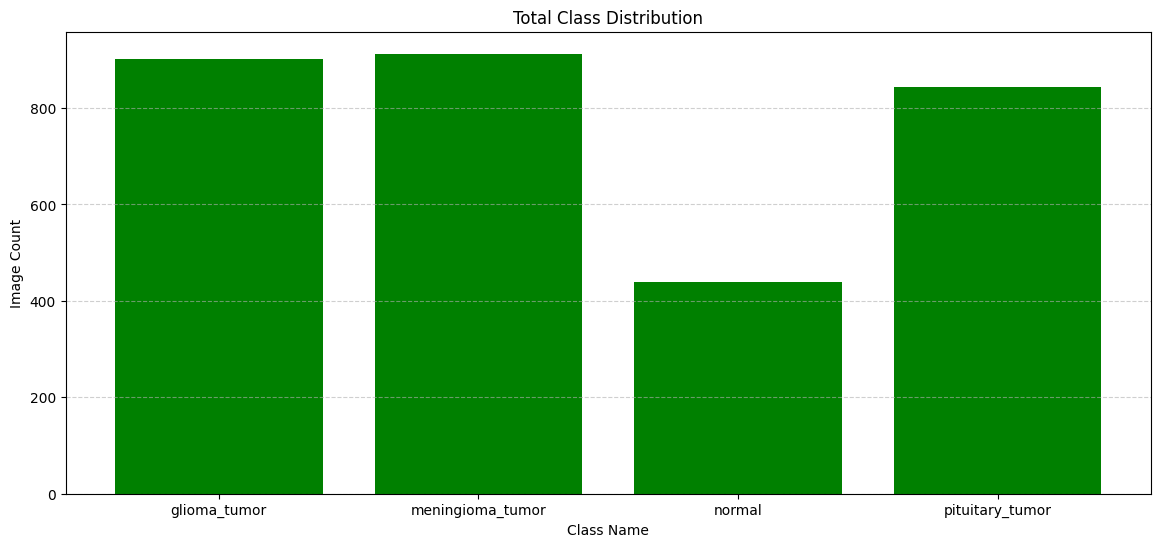

In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(14, 6))  # Create a single Axes object

# Train Plot
ax.bar(total_class_counts.keys(), total_class_counts.values(), color='green') # Use 'ax' directly
ax.set_title("Total Class Distribution")
ax.set_xlabel("Class Name")
ax.set_ylabel("Image Count")
ax.grid(axis='y', linestyle='--', alpha=0.6)

**2. Number of Images Per Class**

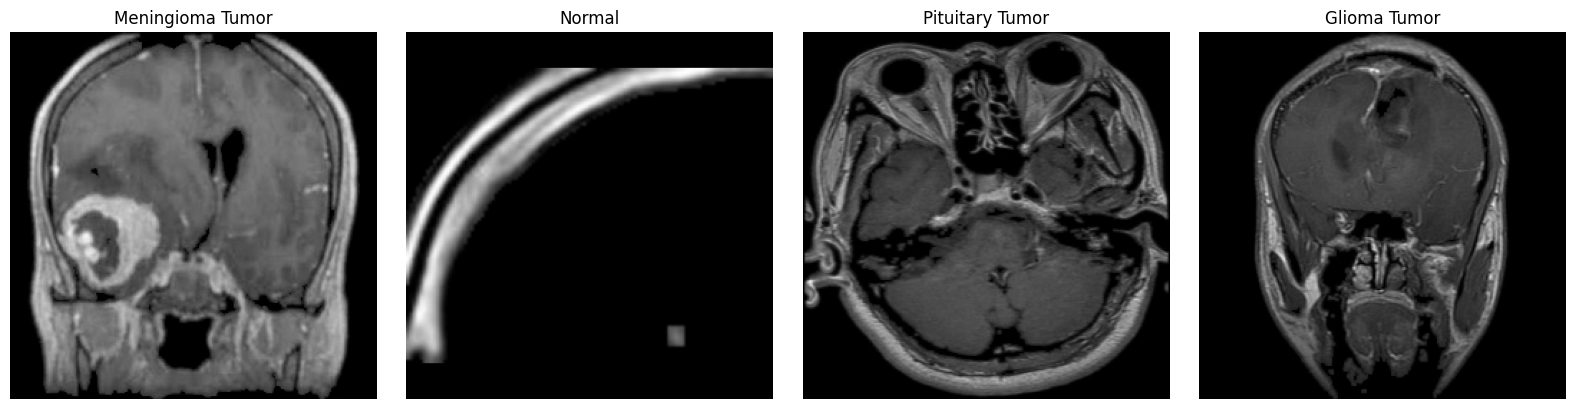

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

class_names = os.listdir(train_dir)

# Initialize figure
plt.figure(figsize=(16, 4))

# Loop through classes and show one image per class
for idx, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        image_files = [img for img in os.listdir(class_path) if img.lower().endswith('.jpg')]
        if image_files:
            image_path = os.path.join(class_path, image_files[0])
            image = Image.open(image_path)
            plt.subplot(1, len(class_names), idx + 1)
            plt.imshow(image, cmap='gray')
            plt.title(class_name.replace("_", " ").title())
            plt.axis('off')

plt.tight_layout()
plt.show()


**3. Resolution of images in Train and Test sets**

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Function to collect image dimensions from a folder
def collect_image_sizes(base_dir):
    widths = []
    heights = []
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith('.jpg'):
                    img_path = os.path.join(class_path, img_name)
                    try:
                        with Image.open(img_path) as img:
                            w, h = img.size
                            widths.append(w)
                            heights.append(h)
                    except:
                        continue
    return widths, heights

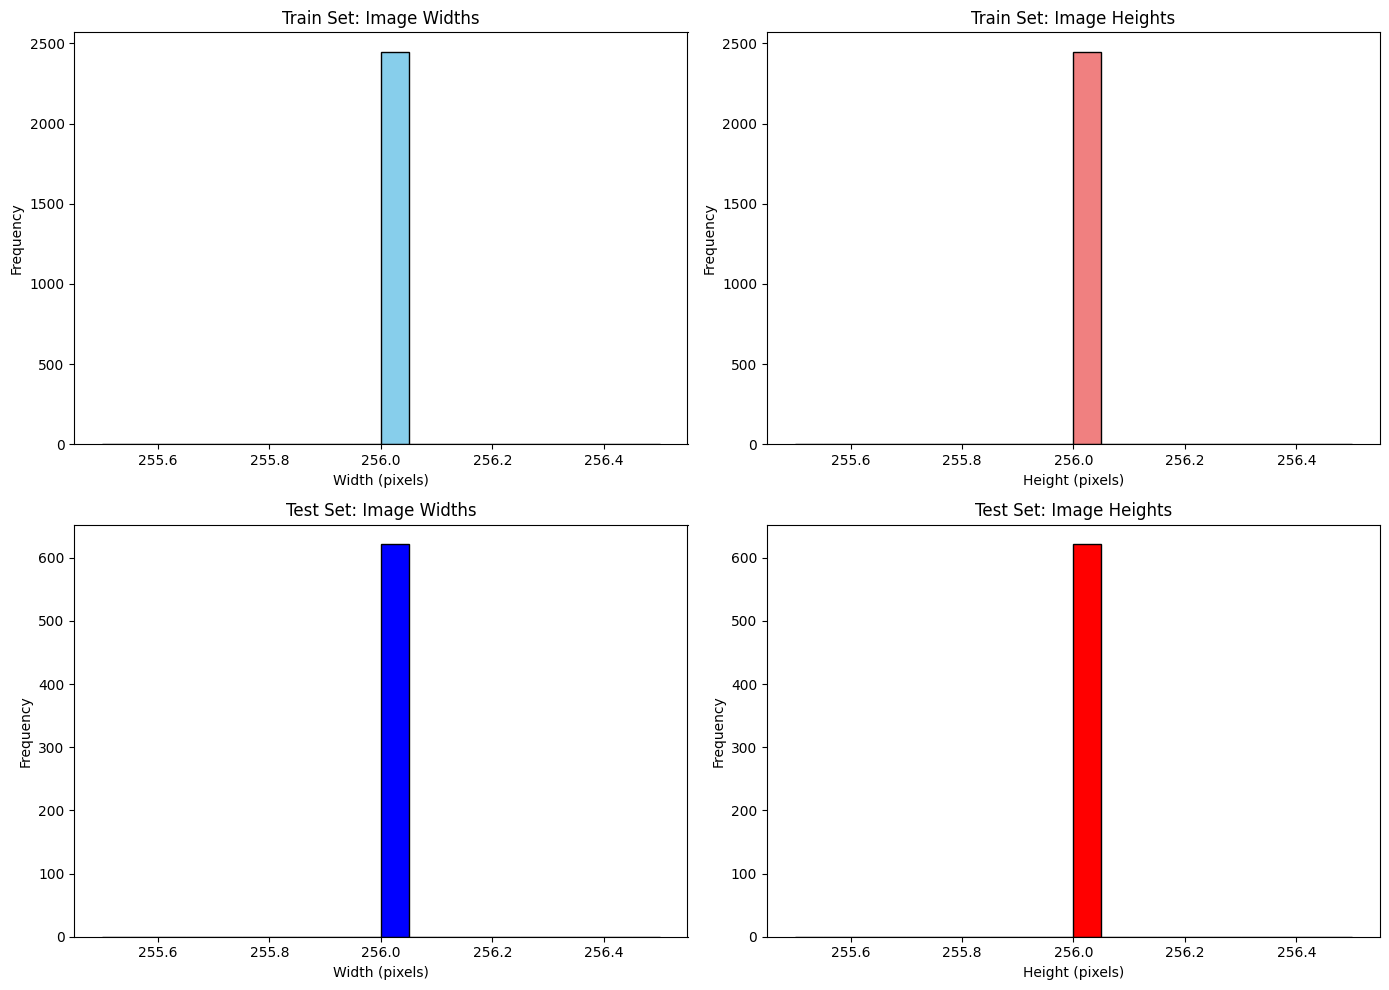

In [ ]:
# Collect dimensions
train_widths, train_heights = collect_image_sizes(train_dir)
test_widths, test_heights = collect_image_sizes(test_dir)

# Plotting
plt.figure(figsize=(14, 10))

# Train - Width
plt.subplot(2, 2, 1)
plt.hist(train_widths, bins=20, color='skyblue', edgecolor='black')
plt.title('Train Set: Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

# Train - Height
plt.subplot(2, 2, 2)
plt.hist(train_heights, bins=20, color='lightcoral', edgecolor='black')
plt.title('Train Set: Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

# Test - Width
plt.subplot(2, 2, 3)
plt.hist(test_widths, bins=20, color='blue', edgecolor='black')
plt.title('Test Set: Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

# Test - Height
plt.subplot(2, 2, 4)
plt.hist(test_heights, bins=20, color='red', edgecolor='black')
plt.title('Test Set: Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


## **1.2. Design, Train, and Evaluate a Baseline Model**

### **1.2.1 Model Architecture**

**1. Splitting the training_ds and validation_ds**

In [ ]:
image_size = (150, 150)
batch_size = 32

train_ds, val_ds = keras.utils.image_dataset_from_directory(
train_dir,
validation_split=0.1,
subset="both",
seed=1337,
image_size=image_size, # Resizing Images just in case
batch_size=batch_size,
)

Found 2447 files belonging to 4 classes.
Using 2203 files for training.
Using 244 files for validation.


In [ ]:
test_ds = keras.utils.image_dataset_from_directory(
    test_dir,                    # path to your test data folder
    image_size=image_size,      # must match training image size
    batch_size=batch_size,      # must match for consistency
)

Found 621 files belonging to 4 classes.


In [ ]:
for images, labels in train_ds.take(1): # Take one batch
  print("Images shape:", images.shape)
  print("Labels shape:", labels.shape)

Images shape: (32, 150, 150, 3)
Labels shape: (32,)


**2. Visuializing Training Dataset**

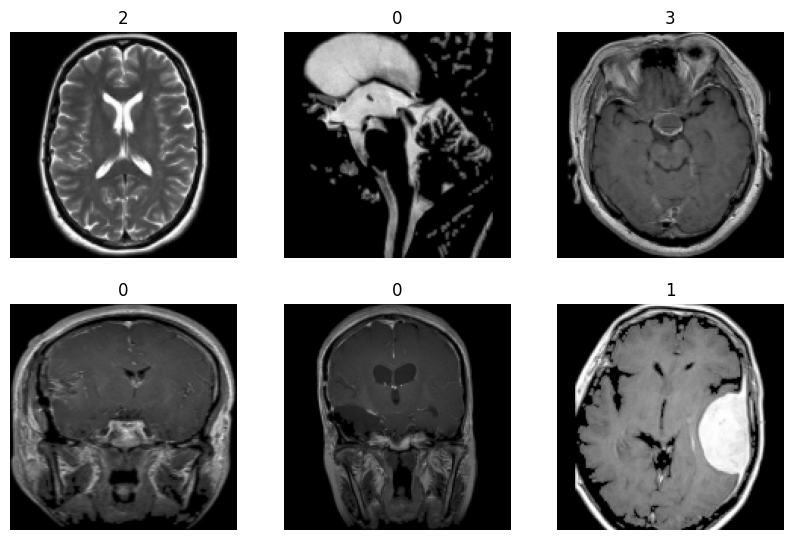

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(images[i]).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

**3. Model Architecture**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Initialize the Sequential model
baseline_model = Sequential()

# Block 1: Convolution + Pooling
baseline_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)))  # Input layer
baseline_model.add(MaxPooling2D((2, 2)))  # Pooling layer

# Block 2: Convolution + Pooling
baseline_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
baseline_model.add(MaxPooling2D((2, 2)))  # Pooling layer

# Block 3: Convolution + Pooling
baseline_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
baseline_model.add(MaxPooling2D((2, 2)))  # Pooling layer

# Flatten the feature maps for fully connected layers
baseline_model.add(Flatten())  # Flatten the 3D feature maps to 1D vector

# Fully Connected Layers (FCN)
baseline_model.add(Dense(128, activation='relu'))  # First fully connected layer
baseline_model.add(Dense(64, activation='relu'))   # Second fully connected layer
baseline_model.add(Dense(32, activation='relu'))   # Third fully connected layer

# Output Layer (suitable for classification)
baseline_model.add(Dense(4, activation='softmax'))  # 4 classes (glioma_tumor, meningioma_tumor, normal, pituitary_tumor)

# Compile the baseline_model
baseline_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print baseline_model summary
baseline_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,412,260 (20.65 MB)

 Trainable params: 5,412,260 (20.65 MB)

 Non-trainable params: 0 (0.00 B)

### **1.2.2 Model Training**

In [ ]:
# Measure training time for baseline model
start_time = time.time()
epochs=10
history = baseline_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)
baseline_training_time = time.time() - start_time
baseline_memory = get_memory_usage()

Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - accuracy: 0.3929 - loss: 9.4286 - val_accuracy: 0.4918 - val_loss: 1.0752
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.6355 - loss: 0.8998 - val_accuracy: 0.6967 - val_loss: 0.7745
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7768 - loss: 0.5595 - val_accuracy: 0.6557 - val_loss: 0.8178
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8388 - loss: 0.4222 - val_accuracy: 0.7377 - val_loss: 0.8954
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8857 - loss: 0.2837 - val_accuracy: 0.7172 - val_loss: 1.0096
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9517 - loss: 0.1442 - val_accuracy: 0.7377 - val_loss: 0.9548
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9812 - loss: 0.0677 - val_accuracy: 0.7500 - val_loss: 1.2253
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9728 - loss: 0.0632 - val_accuracy: 0.8238 

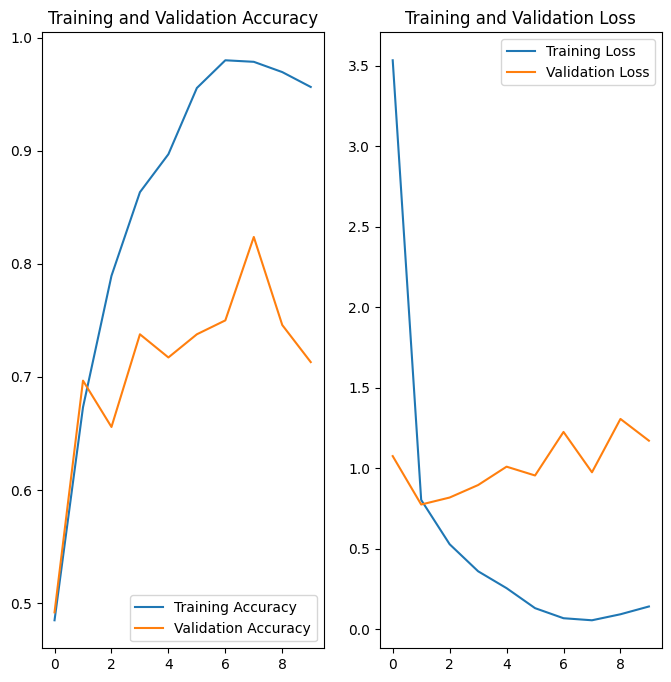

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **1.2.3 Model Evaluation**

**1. Evaluate the model using appropriate metrics**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = []
y_pred = []

class_names = val_ds.class_names

for images, labels in val_ds:
    preds = baseline_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("=== Baseline Model : Validation Set ===")

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix (optional but useful)
print("Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
=== Baseline Model : Validation Set ===
Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       0.89      0.42      0.57        81
meningioma_tumor       0.54      0.90      0.67        63
          normal       0.88      0.79      0.83        38
 pituitary_tumor       0.80      0.85      0.83        62

        accuracy                           0.71       244
       macro avg       0.78      0.74      0.73       244
    weighted avg       0.78      0.71      0.70       244

Confusion Matrix:

[[34 37  3  7]
 [ 2 57  0  4]
 [ 0  6 30  2]
 [ 2  6  1 53]]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = []
y_pred = []

class_names = test_ds.class_names

for images, labels in test_ds:
    preds = baseline_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("=== Baseline Model : Test Set ===")

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix (optional but useful)
print("Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
=== Baseline Model : Test Set ===
Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       0.90      0.57      0.70       181
meningioma_tumor       0.60      0.87      0.71       183
      

**2. Perform inference on sample images and plot the result.**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


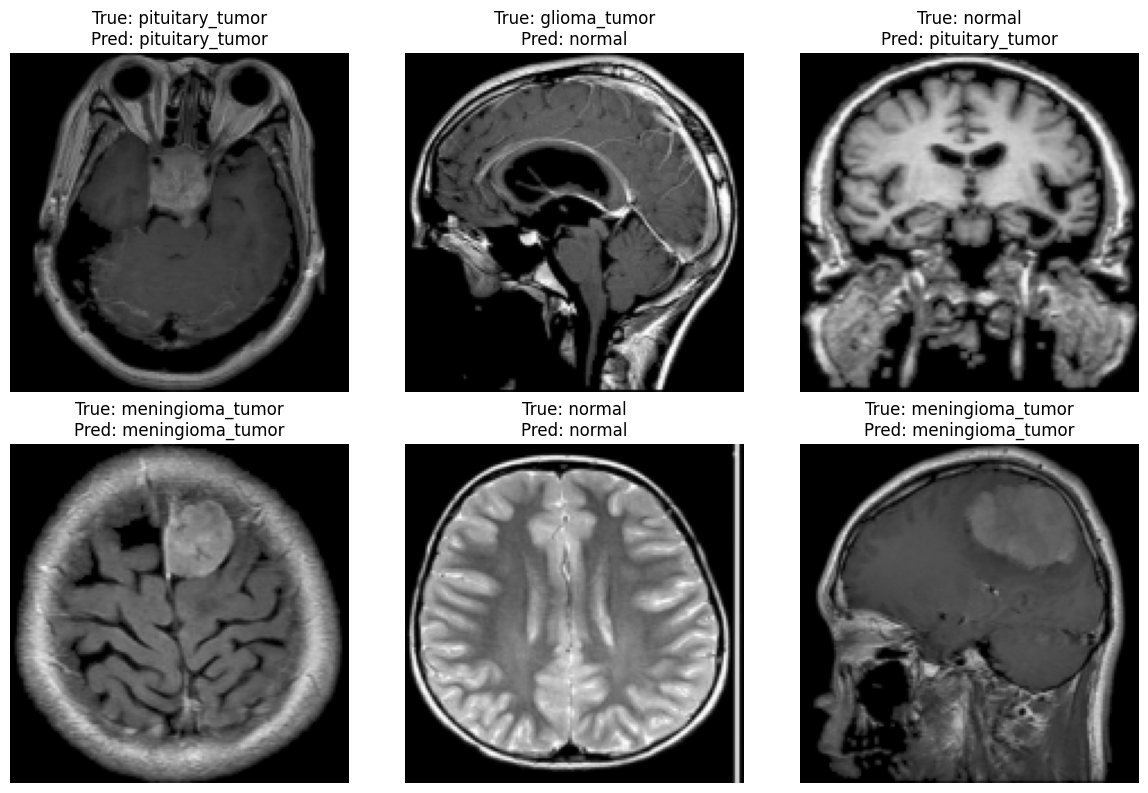

In [ ]:
import matplotlib.pyplot as plt

for images, labels in val_ds.take(1):
    preds = baseline_model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    true_classes = labels.numpy()

    plt.figure(figsize=(12, 8))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[true_classes[i]]}\nPred: {class_names[predicted_classes[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break

**3. Key observations on the modal**

The base model is performing very well already without any overfitting techniques. The accuracy of the base model is above 85%, nearing close to 90%. It has an accuracy of 88%.

Also, the F1 score for most of the classes is above 85%. However, the model seems to be confused upon distinguishing meningioma and giloma maybe because of limited amount of data or likely features between two classes.

Even though the accuracy is satisfying, the model is undenibly overfitting. It might be due to the samll amount of images in the dataset.

Handing overfitting with various techniques might help to balance the model.

## **1.3. Design, Train , and Evaluate Deeper Architecture with Regularization Layer**

### **Data Augmentation**

In [ ]:
# Step 1: Get class names and meningioma index
class_names = train_ds.class_names  # Or val_ds.class_names
meningioma_index = class_names.index("meningioma_tumor")

# Step 2: Define augmentation
augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Step 3: Apply to meningioma only
def augment_meningioma(image, label):
    if label == meningioma_index:  # Use dynamic index
        return augmentation_layers(image), label
    return image, label

train_ds_augmented = train_ds.map(augment_meningioma)

### **1.3.1 Model Architecture**

**1. Splitting the training_ds and validation_ds**

In [ ]:
image_size = (150, 150)
batch_size = 32

train_ds, val_ds = keras.utils.image_dataset_from_directory(
train_dir,
validation_split=0.1,
subset="both",
seed=1337,
image_size=image_size, # Resizing Images just in case
batch_size=batch_size,
)

Found 2447 files belonging to 4 classes.
Using 2203 files for training.
Using 244 files for validation.


**2. Model Architecture:**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

weight_decay = 1e-4  # L2 regularization factor

model = Sequential()

# Block 1
model.add(Conv2D(16, (3, 3), activation='relu', padding='same',
                 kernel_regularizer=l2(weight_decay), input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((3,3)))
model.add(Dropout(0.2))

# Block 2
model.add(Conv2D(32, (3, 3), activation='relu', padding='same',
                 kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(MaxPooling2D((3,3)))
model.add(Dropout(0.2))

# Block 3
model.add(Conv2D(64, (3, 3), activation='relu', padding='same',
                 kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(MaxPooling2D((3,3)))
model.add(Dropout(0.2))

# Flatten and Dense
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))  # 4 classes

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 150, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 150, 150, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 50, 50, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 16)             │             

 Total params: 129,620 (506.33 KB)

 Trainable params: 129,172 (504.58 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("best_model.h5",
                             monitor="val_loss",
                             save_best_only=True,
                             mode="min",
                             verbose=1)

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss",patience=15, restore_best_weights=True)

### **1.3.2 Model Training**

In [ ]:
import matplotlib.pyplot as plt
start_time = time.time()

epochs = 150

# Training the model
deeper_history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[early_stopping,checkpoint],
)
deeper_training_time = time.time() - start_time
deeper_memory = get_memory_usage()

Epoch 1/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.2685 - loss: 1.9522
Epoch 1: val_loss improved from inf to 1.42268, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 25s 180ms/step - accuracy: 0.2687 - loss: 1.9516 - val_accuracy: 0.2582 - val_loss: 1.4227
Epoch 2/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3084 - loss: 1.7894
Epoch 2: val_loss improved from 1.42268 to 1.38804, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.3086 - loss: 1.7885 - val_accuracy: 0.2705 - val_loss: 1.3880
Epoch 3/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3245 - loss: 1.6326
Epoch 3: val_loss improved from 1.38804 to 1.34354, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3250 - loss: 1.6326 - val_accuracy: 0.2951 - val_loss: 1.3435
Epoch 4/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3976 - loss: 1.5147
Epoch 4: val_loss improved from 1.34354 to 1.29682, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3971 - loss: 1.5154 - val_accuracy: 0.3811 - val_loss: 1.2968
Epoch 5/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3689 - loss: 1.5557
Epoch 5: val_loss improved from 1.29682 to 1.25364, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3689 - loss: 1.5557 - val_accuracy: 0.4508 - val_loss: 1.2536
Epoch 6/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4012 - loss: 1.4810
Epoch 6: val_loss improved from 1.25364 to 1.21473, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.4015 - loss: 1.4798 - val_accuracy: 0.4590 - val_loss: 1.2147
Epoch 7/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4240 - loss: 1.4481
Epoch 7: val_loss improved from 1.21473 to 1.20196, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4240 - loss: 1.4477 - val_accuracy: 0.5000 - val_loss: 1.2020
Epoch 8/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4130 - loss: 1.4225
Epoch 8: val_loss improved from 1.20196 to 1.19438, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.4128 - loss: 1.4228 - val_accuracy: 0.4836 - val_loss: 1.1944
Epoch 9/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4436 - loss: 1.3479
Epoch 9: val_loss did not improve from 1.19438
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4436 - loss: 1.3479 - val_accuracy: 0.4754 - val_loss: 1.2111
Epoch 10/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4506 - loss: 1.3306
Epoch 10: val_loss improved from 1.19438 to 1.16581, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.4503 - loss: 1.3312 - val_accuracy: 0.5164 - val_loss: 1.1658
Epoch 11/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4596 - loss: 1.3029
Epoch 11: val_loss improved from 1.16581 to 1.15709, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.4595 - loss: 1.3030 - val_accuracy: 0.5205 - val_loss: 1.1571
Epoch 12/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4798 - loss: 1.2843
Epoch 12: val_loss improved from 1.15709 to 1.15699, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.4795 - loss: 1.2845 - val_accuracy: 0.5123 - val_loss: 1.1570
Epoch 13/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4739 - loss: 1.2298
Epoch 13: val_loss improved from 1.15699 to 1.14430, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.4737 - loss: 1.2301 - val_accuracy: 0.5123 - val_loss: 1.1443
Epoch 14/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5078 - loss: 1.2308
Epoch 14: val_loss improved from 1.14430 to 1.12920, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5077 - loss: 1.2308 - val_accuracy: 0.5164 - val_loss: 1.1292
Epoch 15/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5033 - loss: 1.2145
Epoch 15: val_loss improved from 1.12920 to 1.12069, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5031 - loss: 1.2145 - val_accuracy: 0.5287 - val_loss: 1.1207
Epoch 16/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5075 - loss: 1.2227
Epoch 16: val_loss improved from 1.12069 to 1.11450, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5076 - loss: 1.2222 - val_accuracy: 0.5205 - val_loss: 1.1145
Epoch 17/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5218 - loss: 1.1454
Epoch 17: val_loss improved from 1.11450 to 1.10484, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5217 - loss: 1.1458 - val_accuracy: 0.5123 - val_loss: 1.1048
Epoch 18/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5093 - loss: 1.1863
Epoch 18: val_loss improved from 1.10484 to 1.07919, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5096 - loss: 1.1860 - val_accuracy: 0.5574 - val_loss: 1.0792
Epoch 19/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5222 - loss: 1.1683
Epoch 19: val_loss improved from 1.07919 to 1.06343, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5223 - loss: 1.1681 - val_accuracy: 0.5697 - val_loss: 1.0634
Epoch 20/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5507 - loss: 1.1305
Epoch 20: val_loss improved from 1.06343 to 1.04238, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5507 - loss: 1.1304 - val_accuracy: 0.5615 - val_loss: 1.0424
Epoch 21/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5607 - loss: 1.0642
Epoch 21: val_loss did not improve from 1.04238
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5606 - loss: 1.0644 - val_accuracy: 0.5492 - val_loss: 1.0436
Epoch 22/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5547 - loss: 1.0736
Epoch 22: val_loss did not improve from 1.04238
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.5546 - loss: 1.0736 - val_accuracy: 0.5574 - val_loss: 1.0425
Epoch 23/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5305 - loss: 1.1506
Epoch 23: val_loss improved from 1.04238 to 1.03089, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.5307 - loss: 1.1503 - val_accuracy: 0.5820 - val_loss: 1.0309
Epoch 24/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5568 - loss: 1.0981
Epoch 24: val_loss did not improve from 1.03089
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5568 - loss: 1.0980 - val_accuracy: 0.5533 - val_loss: 1.0513
Epoch 25/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5767 - loss: 1.0722
Epoch 25: val_loss improved from 1.03089 to 1.02072, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5766 - loss: 1.0724 - val_accuracy: 0.5656 - val_loss: 1.0207
Epoch 26/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5547 - loss: 1.0808
Epoch 26: val_loss improved from 1.02072 to 1.00178, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5546 - loss: 1.0807 - val_accuracy: 0.5984 - val_loss: 1.0018
Epoch 27/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5626 - loss: 1.0749
Epoch 27: val_loss improved from 1.00178 to 0.99221, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.5631 - loss: 1.0743 - val_accuracy: 0.5943 - val_loss: 0.9922
Epoch 28/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5887 - loss: 1.0413
Epoch 28: val_loss improved from 0.99221 to 0.97713, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5885 - loss: 1.0416 - val_accuracy: 0.6025 - val_loss: 0.9771
Epoch 29/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5804 - loss: 1.0516
Epoch 29: val_loss did not improve from 0.97713
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5805 - loss: 1.0514 - val_accuracy: 0.6066 - val_loss: 0.9828
Epoch 30/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5874 - loss: 1.0399
Epoch 30: val_loss improved from 0.97713 to 0.97523, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5874 - loss: 1.0399 - val_accuracy: 0.6025 - val_loss: 0.9752
Epoch 31/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5945 - loss: 1.0020
Epoch 31: val_loss improved from 0.97523 to 0.96277, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5945 - loss: 1.0021 - val_accuracy: 0.6066 - val_loss: 0.9628
Epoch 32/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5912 - loss: 0.9992
Epoch 32: val_loss improved from 0.96277 to 0.95403, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5912 - loss: 0.9993 - val_accuracy: 0.6189 - val_loss: 0.9540
Epoch 33/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5908 - loss: 1.0001
Epoch 33: val_loss improved from 0.95403 to 0.93754, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5909 - loss: 1.0003 - val_accuracy: 0.6270 - val_loss: 0.9375
Epoch 34/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6074 - loss: 0.9784
Epoch 34: val_loss improved from 0.93754 to 0.92848, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6073 - loss: 0.9786 - val_accuracy: 0.6189 - val_loss: 0.9285
Epoch 35/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6292 - loss: 0.9601
Epoch 35: val_loss improved from 0.92848 to 0.91832, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.6291 - loss: 0.9602 - val_accuracy: 0.6270 - val_loss: 0.9183
Epoch 36/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6446 - loss: 0.9276
Epoch 36: val_loss improved from 0.91832 to 0.90085, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.6445 - loss: 0.9277 - val_accuracy: 0.6516 - val_loss: 0.9008
Epoch 37/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6231 - loss: 0.9622
Epoch 37: val_loss did not improve from 0.90085
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6236 - loss: 0.9612 - val_accuracy: 0.6311 - val_loss: 0.9072
Epoch 38/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6239 - loss: 0.9477
Epoch 38: val_loss did not improve from 0.90085
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6241 - loss: 0.9473 - val_accuracy: 0.6434 - val_loss: 0.9053
Epoch 39/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6399 - loss: 0.9408
Epoch 39: val_loss improved from 0.90085 to 0.88866, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6400 - loss: 0.9403 - val_accuracy: 0.6434 - val_loss: 0.8887
Epoch 40/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6365 - loss: 0.9364
Epoch 40: val_loss improved from 0.88866 to 0.87620, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6364 - loss: 0.9363 - val_accuracy: 0.6762 - val_loss: 0.8762
Epoch 41/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6218 - loss: 0.9479
Epoch 41: val_loss improved from 0.87620 to 0.86366, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6219 - loss: 0.9476 - val_accuracy: 0.6844 - val_loss: 0.8637
Epoch 42/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6331 - loss: 0.9193
Epoch 42: val_loss improved from 0.86366 to 0.85768, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6331 - loss: 0.9193 - val_accuracy: 0.6721 - val_loss: 0.8577
Epoch 43/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6349 - loss: 0.8953
Epoch 43: val_loss did not improve from 0.85768
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6350 - loss: 0.8953 - val_accuracy: 0.6762 - val_loss: 0.8799
Epoch 44/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6481 - loss: 0.8866
Epoch 44: val_loss improved from 0.85768 to 0.84350, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.6479 - loss: 0.8867 - val_accuracy: 0.6885 - val_loss: 0.8435
Epoch 45/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6612 - loss: 0.8906
Epoch 45: val_loss improved from 0.84350 to 0.82384, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.6611 - loss: 0.8905 - val_accuracy: 0.6885 - val_loss: 0.8238
Epoch 46/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6598 - loss: 0.8809
Epoch 46: val_loss improved from 0.82384 to 0.80693, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.6596 - loss: 0.8808 - val_accuracy: 0.7131 - val_loss: 0.8069
Epoch 47/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6413 - loss: 0.8992
Epoch 47: val_loss did not improve from 0.80693
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6413 - loss: 0.8993 - val_accuracy: 0.7090 - val_loss: 0.8160
Epoch 48/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6563 - loss: 0.8603
Epoch 48: val_loss improved from 0.80693 to 0.80404, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6563 - loss: 0.8606 - val_accuracy: 0.7049 - val_loss: 0.8040
Epoch 49/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6652 - loss: 0.8516
Epoch 49: val_loss improved from 0.80404 to 0.79722, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6652 - loss: 0.8515 - val_accuracy: 0.7090 - val_loss: 0.7972
Epoch 50/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6572 - loss: 0.8528
Epoch 50: val_loss did not improve from 0.79722
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6571 - loss: 0.8529 - val_accuracy: 0.7131 - val_loss: 0.8082
Epoch 51/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6889 - loss: 0.8200
Epoch 51: val_loss did not improve from 0.79722
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6887 - loss: 0.8202 - val_accuracy: 0.7172 - val_loss: 0.7975
Epoch 52/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6943 - loss: 0.8207
Epoch 52: val_loss improved from 0.79722 to 0.79644, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6943 - loss: 0.8207 - val_accuracy: 0.7172 - val_loss: 0.7964
Epoch 53/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6862 - loss: 0.8015
Epoch 53: val_loss improved from 0.79644 to 0.77201, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6860 - loss: 0.8016 - val_accuracy: 0.7049 - val_loss: 0.7720
Epoch 54/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6818 - loss: 0.8334
Epoch 54: val_loss did not improve from 0.77201
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6817 - loss: 0.8334 - val_accuracy: 0.7172 - val_loss: 0.7739
Epoch 55/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6993 - loss: 0.8211
Epoch 55: val_loss did not improve from 0.77201
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6990 - loss: 0.8213 - val_accuracy: 0.7172 - val_loss: 0.7873
Epoch 56/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6978 - loss: 0.8136
Epoch 56: val_loss improved from 0.77201 to 0.75765, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6975 - loss: 0.8137 - val_accuracy: 0.7172 - val_loss: 0.7577
Epoch 57/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7024 - loss: 0.8075
Epoch 57: val_loss did not improve from 0.75765
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7022 - loss: 0.8075 - val_accuracy: 0.7172 - val_loss: 0.7788
Epoch 58/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6926 - loss: 0.7822
Epoch 58: val_loss improved from 0.75765 to 0.74765, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.6923 - loss: 0.7830 - val_accuracy: 0.7254 - val_loss: 0.7476
Epoch 59/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6837 - loss: 0.8087
Epoch 59: val_loss improved from 0.74765 to 0.73876, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6837 - loss: 0.8085 - val_accuracy: 0.7131 - val_loss: 0.7388
Epoch 60/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6916 - loss: 0.7879
Epoch 60: val_loss improved from 0.73876 to 0.73625, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6916 - loss: 0.7880 - val_accuracy: 0.7295 - val_loss: 0.7363
Epoch 61/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7089 - loss: 0.7591
Epoch 61: val_loss improved from 0.73625 to 0.72794, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7088 - loss: 0.7594 - val_accuracy: 0.7131 - val_loss: 0.7279
Epoch 62/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6966 - loss: 0.7629
Epoch 62: val_loss improved from 0.72794 to 0.72419, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6967 - loss: 0.7629 - val_accuracy: 0.7213 - val_loss: 0.7242
Epoch 63/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7090 - loss: 0.7611
Epoch 63: val_loss did not improve from 0.72419
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7090 - loss: 0.7610 - val_accuracy: 0.7295 - val_loss: 0.7292
Epoch 64/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6904 - loss: 0.7703
Epoch 64: val_loss improved from 0.72419 to 0.69674, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6905 - loss: 0.7703 - val_accuracy: 0.7418 - val_loss: 0.6967
Epoch 65/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6962 - loss: 0.7671
Epoch 65: val_loss improved from 0.69674 to 0.68690, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6965 - loss: 0.7667 - val_accuracy: 0.7418 - val_loss: 0.6869
Epoch 66/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7261 - loss: 0.7477
Epoch 66: val_loss improved from 0.68690 to 0.66974, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7260 - loss: 0.7474 - val_accuracy: 0.7459 - val_loss: 0.6697
Epoch 67/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7249 - loss: 0.7578
Epoch 67: val_loss did not improve from 0.66974
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7250 - loss: 0.7574 - val_accuracy: 0.7459 - val_loss: 0.6797
Epoch 68/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7270 - loss: 0.7269
Epoch 68: val_loss improved from 0.66974 to 0.65763, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7270 - loss: 0.7268 - val_accuracy: 0.7664 - val_loss: 0.6576
Epoch 69/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7311 - loss: 0.7505
Epoch 69: val_loss did not improve from 0.65763
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7308 - loss: 0.7505 - val_accuracy: 0.7623 - val_loss: 0.6580
Epoch 70/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7335 - loss: 0.7065
Epoch 70: val_loss did not improve from 0.65763
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7335 - loss: 0.7066 - val_accuracy: 0.7377 - val_loss: 0.6606
Epoch 71/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7487 - loss: 0.7248
Epoch 71: val_loss improved from 0.65763 to 0.65135, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7486 - loss: 0.7245 - val_accuracy: 0.7664 - val_loss: 0.6513
Epoch 72/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7342 - loss: 0.6926
Epoch 72: val_loss improved from 0.65135 to 0.63976, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7343 - loss: 0.6925 - val_accuracy: 0.7664 - val_loss: 0.6398
Epoch 73/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7316 - loss: 0.6946
Epoch 73: val_loss improved from 0.63976 to 0.63111, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7321 - loss: 0.6941 - val_accuracy: 0.7582 - val_loss: 0.6311
Epoch 74/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7516 - loss: 0.6916
Epoch 74: val_loss did not improve from 0.63111
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.7517 - loss: 0.6915 - val_accuracy: 0.7459 - val_loss: 0.6403
Epoch 75/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7479 - loss: 0.6796
Epoch 75: val_loss did not improve from 0.63111
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7477 - loss: 0.6798 - val_accuracy: 0.7541 - val_loss: 0.6317
Epoch 76/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7540 - loss: 0.6705
Epoch 76: val_loss improved from 0.63111 to 0.61993, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7540 - loss: 0.6707 - val_accuracy: 0.7705 - val_loss: 0.6199
Epoch 77/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7417 - loss: 0.6997
Epoch 77: val_loss did not improve from 0.61993
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7418 - loss: 0.6993 - val_accuracy: 0.7541 - val_loss: 0.6254
Epoch 78/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7333 - loss: 0.6743
Epoch 78: val_loss improved from 0.61993 to 0.60245, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7337 - loss: 0.6740 - val_accuracy: 0.7746 - val_loss: 0.6024
Epoch 79/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7689 - loss: 0.6624
Epoch 79: val_loss did not improve from 0.60245
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7690 - loss: 0.6623 - val_accuracy: 0.7705 - val_loss: 0.6296
Epoch 80/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7480 - loss: 0.6584
Epoch 80: val_loss improved from 0.60245 to 0.60156, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7482 - loss: 0.6583 - val_accuracy: 0.7746 - val_loss: 0.6016
Epoch 81/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7589 - loss: 0.6475
Epoch 81: val_loss improved from 0.60156 to 0.60050, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7592 - loss: 0.6475 - val_accuracy: 0.7664 - val_loss: 0.6005
Epoch 82/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7561 - loss: 0.6835
Epoch 82: val_loss improved from 0.60050 to 0.59480, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7561 - loss: 0.6833 - val_accuracy: 0.7664 - val_loss: 0.5948
Epoch 83/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7686 - loss: 0.6478
Epoch 83: val_loss did not improve from 0.59480
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7685 - loss: 0.6479 - val_accuracy: 0.7500 - val_loss: 0.6232
Epoch 84/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7745 - loss: 0.6316
Epoch 84: val_loss improved from 0.59480 to 0.57484, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7744 - loss: 0.6320 - val_accuracy: 0.7869 - val_loss: 0.5748
Epoch 85/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7622 - loss: 0.6446
Epoch 85: val_loss did not improve from 0.57484
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7624 - loss: 0.6442 - val_accuracy: 0.7746 - val_loss: 0.6079
Epoch 86/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7848 - loss: 0.6063
Epoch 86: val_loss did not improve from 0.57484
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.7847 - loss: 0.6064 - val_accuracy: 0.7787 - val_loss: 0.5895
Epoch 87/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7721 - loss: 0.6220
Epoch 87: val_loss improved from 0.57484 to 0.57080, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7722 - loss: 0.6223 - val_accuracy: 0.7828 - val_loss: 0.5708
Epoch 88/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7467 - loss: 0.6548
Epoch 88: val_loss did not improve from 0.57080
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7472 - loss: 0.6544 - val_accuracy: 0.7951 - val_loss: 0.5769
Epoch 89/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7794 - loss: 0.6000
Epoch 89: val_loss improved from 0.57080 to 0.56822, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7792 - loss: 0.6005 - val_accuracy: 0.7869 - val_loss: 0.5682
Epoch 90/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7791 - loss: 0.6279
Epoch 90: val_loss did not improve from 0.56822
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7793 - loss: 0.6270 - val_accuracy: 0.8074 - val_loss: 0.5822
Epoch 91/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7919 - loss: 0.6056
Epoch 91: val_loss improved from 0.56822 to 0.56812, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.7918 - loss: 0.6056 - val_accuracy: 0.7705 - val_loss: 0.5681
Epoch 92/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7952 - loss: 0.5938
Epoch 92: val_loss improved from 0.56812 to 0.55579, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7952 - loss: 0.5938 - val_accuracy: 0.7910 - val_loss: 0.5558
Epoch 93/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8100 - loss: 0.5643
Epoch 93: val_loss did not improve from 0.55579
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8097 - loss: 0.5649 - val_accuracy: 0.7951 - val_loss: 0.5869
Epoch 94/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7819 - loss: 0.5981
Epoch 94: val_loss did not improve from 0.55579
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7819 - loss: 0.5980 - val_accuracy: 0.7951 - val_loss: 0.5607
Epoch 95/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8042 - loss: 0.5423
Epoch 95: val_loss did not improve from 0.55579
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8042 - loss: 0.5425 - val_accuracy: 0.7992 - val_loss: 0.5686
Epoch 96/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7781 - loss: 0.6217
Epoch 96: val_loss did not improve from 0.55

69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7963 - loss: 0.5641 - val_accuracy: 0.8115 - val_loss: 0.5442
Epoch 100/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8081 - loss: 0.5641
Epoch 100: val_loss improved from 0.54425 to 0.54121, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8082 - loss: 0.5644 - val_accuracy: 0.8197 - val_loss: 0.5412
Epoch 101/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8157 - loss: 0.5542
Epoch 101: val_loss did not improve from 0.54121
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8157 - loss: 0.5542 - val_accuracy: 0.8156 - val_loss: 0.5422
Epoch 102/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8123 - loss: 0.5439
Epoch 102: val_loss did not improve from 0.54121
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8122 - loss: 0.5440 - val_accuracy: 0.7910 - val_loss: 0.5667
Epoch 103/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7994 - loss: 0.5494
Epoch 103: val_loss did not improve from 0.54121
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8000 - loss: 0.5485 - val_accuracy: 0.8074 - val_loss: 0.5566
Epoch 104/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8093 - loss: 0.5277
Epoch 104: val_loss improved from 0.5

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8095 - loss: 0.5274 - val_accuracy: 0.8238 - val_loss: 0.5182
Epoch 105/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8260 - loss: 0.5173
Epoch 105: val_loss improved from 0.51824 to 0.51618, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8261 - loss: 0.5172 - val_accuracy: 0.8361 - val_loss: 0.5162
Epoch 106/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8195 - loss: 0.5093
Epoch 106: val_loss did not improve from 0.51618
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8195 - loss: 0.5094 - val_accuracy: 0.8033 - val_loss: 0.5185
Epoch 107/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8194 - loss: 0.5400
Epoch 107: val_loss did not improve from 0.51618
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8194 - loss: 0.5400 - val_accuracy: 0.8074 - val_loss: 0.5515
Epoch 108/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8255 - loss: 0.5472
Epoch 108: val_loss did not improve from 0.51618
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8255 - loss: 0.5465 - val_accuracy: 0.8238 - val_loss: 0.5243
Epoch 109/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8107 - loss: 0.5282
Epoch 109: val_loss did not improve f

69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8374 - loss: 0.4883 - val_accuracy: 0.8320 - val_loss: 0.5144
Epoch 113/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8119 - loss: 0.5337
Epoch 113: val_loss improved from 0.51441 to 0.49370, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8121 - loss: 0.5330 - val_accuracy: 0.8443 - val_loss: 0.4937
Epoch 114/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8208 - loss: 0.5304
Epoch 114: val_loss did not improve from 0.49370
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8209 - loss: 0.5299 - val_accuracy: 0.8402 - val_loss: 0.5052
Epoch 115/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8186 - loss: 0.5324
Epoch 115: val_loss did not improve from 0.49370
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8188 - loss: 0.5322 - val_accuracy: 0.8197 - val_loss: 0.5055
Epoch 116/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8441 - loss: 0.4881
Epoch 116: val_loss did not improve from 0.49370
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8437 - loss: 0.4886 - val_accuracy: 0.8484 - val_loss: 0.5014
Epoch 117/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8352 - loss: 0.4674
Epoch 117: val_loss did not improve f

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8386 - loss: 0.4916 - val_accuracy: 0.8443 - val_loss: 0.4933
Epoch 122/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8543 - loss: 0.4854
Epoch 122: val_loss did not improve from 0.49329
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8541 - loss: 0.4852 - val_accuracy: 0.8238 - val_loss: 0.5198
Epoch 123/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8389 - loss: 0.4925
Epoch 123: val_loss did not improve from 0.49329
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8389 - loss: 0.4920 - val_accuracy: 0.8361 - val_loss: 0.5172
Epoch 124/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8248 - loss: 0.5063
Epoch 124: val_loss did not improve from 0.49329
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8251 - loss: 0.5055 - val_accuracy: 0.8156 - val_loss: 0.5370
Epoch 125/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8474 - loss: 0.4589
Epoch 125: val_loss improved from 0.4

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8473 - loss: 0.4594 - val_accuracy: 0.8566 - val_loss: 0.4796
Epoch 126/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8451 - loss: 0.4668
Epoch 126: val_loss did not improve from 0.47957
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8452 - loss: 0.4666 - val_accuracy: 0.8361 - val_loss: 0.4866
Epoch 127/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8453 - loss: 0.4891
Epoch 127: val_loss did not improve from 0.47957
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8452 - loss: 0.4885 - val_accuracy: 0.8402 - val_loss: 0.5039
Epoch 128/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8345 - loss: 0.4747
Epoch 128: val_loss did not improve from 0.47957
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8346 - loss: 0.4745 - val_accuracy: 0.8279 - val_loss: 0.5344
Epoch 129/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8473 - loss: 0.4435
Epoch 129: val_loss improved from 0.4

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8473 - loss: 0.4436 - val_accuracy: 0.8607 - val_loss: 0.4733
Epoch 130/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8315 - loss: 0.5001
Epoch 130: val_loss did not improve from 0.47329
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8322 - loss: 0.4987 - val_accuracy: 0.8361 - val_loss: 0.4762
Epoch 131/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8301 - loss: 0.4620
Epoch 131: val_loss did not improve from 0.47329
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.8305 - loss: 0.4616 - val_accuracy: 0.8525 - val_loss: 0.4842
Epoch 132/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8589 - loss: 0.4324
Epoch 132: val_loss did not improve from 0.47329
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8586 - loss: 0.4328 - val_accuracy: 0.8484 - val_loss: 0.4872
Epoch 133/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8531 - loss: 0.4373
Epoch 133: val_loss did not improve f

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8479 - loss: 0.4554 - val_accuracy: 0.8648 - val_loss: 0.4578
Epoch 137/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8354 - loss: 0.4871
Epoch 137: val_loss did not improve from 0.45777
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8356 - loss: 0.4867 - val_accuracy: 0.8402 - val_loss: 0.4844
Epoch 138/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8477 - loss: 0.4567
Epoch 138: val_loss did not improve from 0.45777
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8480 - loss: 0.4559 - val_accuracy: 0.8525 - val_loss: 0.4652
Epoch 139/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8678 - loss: 0.3910
Epoch 139: val_loss improved from 0.45777 to 0.45740, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8675 - loss: 0.3914 - val_accuracy: 0.8566 - val_loss: 0.4574
Epoch 140/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8643 - loss: 0.4125
Epoch 140: val_loss did not improve from 0.45740
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8643 - loss: 0.4127 - val_accuracy: 0.8566 - val_loss: 0.4724
Epoch 141/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8593 - loss: 0.4253
Epoch 141: val_loss improved from 0.45740 to 0.45296, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8593 - loss: 0.4251 - val_accuracy: 0.8689 - val_loss: 0.4530
Epoch 142/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8598 - loss: 0.4240
Epoch 142: val_loss did not improve from 0.45296
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8600 - loss: 0.4237 - val_accuracy: 0.8402 - val_loss: 0.5052
Epoch 143/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8588 - loss: 0.4279
Epoch 143: val_loss improved from 0.45296 to 0.44725, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8589 - loss: 0.4279 - val_accuracy: 0.8607 - val_loss: 0.4473
Epoch 144/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8743 - loss: 0.4018
Epoch 144: val_loss did not improve from 0.44725
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8740 - loss: 0.4022 - val_accuracy: 0.8484 - val_loss: 0.4735
Epoch 145/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8601 - loss: 0.4127
Epoch 145: val_loss did not improve from 0.44725
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8601 - loss: 0.4127 - val_accuracy: 0.8525 - val_loss: 0.4625
Epoch 146/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8545 - loss: 0.4452
Epoch 146: val_loss did not improve from 0.44725
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8545 - loss: 0.4451 - val_accuracy: 0.8156 - val_loss: 0.5218
Epoch 147/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8489 - loss: 0.4332
Epoch 147: val_loss did not improve f

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8726 - loss: 0.4215 - val_accuracy: 0.8730 - val_loss: 0.4461
Epoch 149/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8756 - loss: 0.3782
Epoch 149: val_loss did not improve from 0.44607
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8753 - loss: 0.3786 - val_accuracy: 0.8525 - val_loss: 0.4574
Epoch 150/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8657 - loss: 0.4311
Epoch 150: val_loss improved from 0.44607 to 0.43691, saving model to best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8658 - loss: 0.4304 - val_accuracy: 0.8852 - val_loss: 0.4369


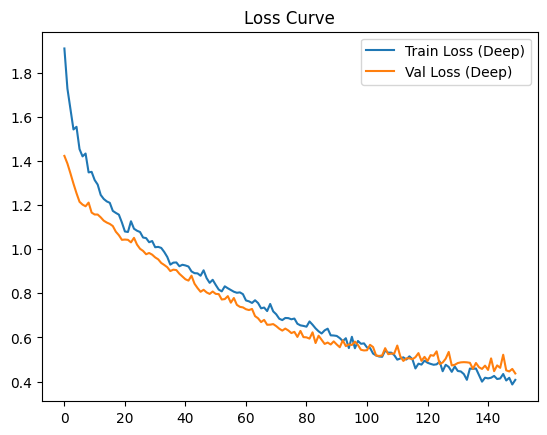

In [ ]:
# Plot loss and accuracy
plt.plot(deeper_history.history['loss'], label='Train Loss (Deep)')
plt.plot(deeper_history.history['val_loss'], label='Val Loss (Deep)')
# plt.plot(history_baseline.history['val_loss'], label='Val Loss (Baseline)')
plt.title('Loss Curve')
plt.legend()
plt.show()

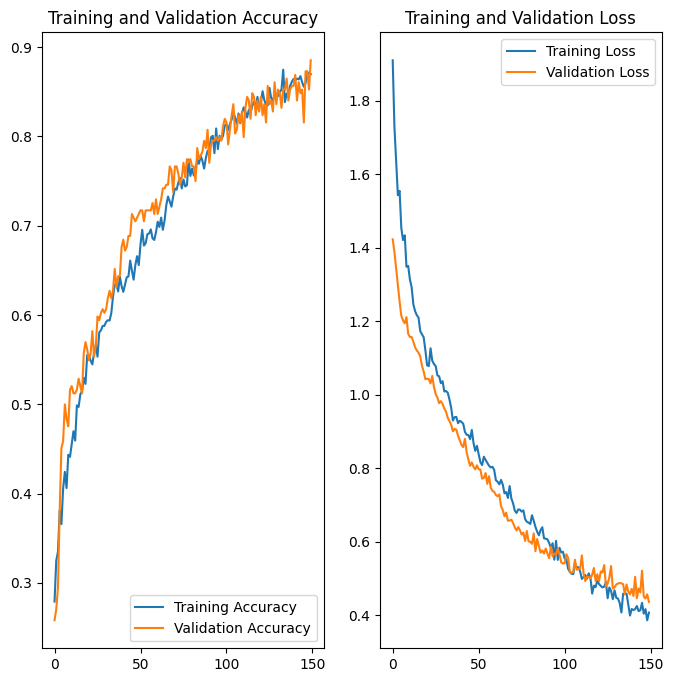

In [ ]:
trained_epochs = len(history.history['loss'])

acc = deeper_history.history['accuracy']
val_acc = deeper_history.history['val_accuracy']

loss = deeper_history.history['loss']
val_loss = deeper_history.history['val_loss']

epochs_range = range(trained_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **1.3.3 Model Evaluation**

**1. Evaluate the model using appropriate metrics**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = []
y_pred = []

class_names = val_ds.class_names

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("=== Deeper Model : Validation Set ===")

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix (optional but useful)
print("Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
=== Deeper Model : Validation Set ===
Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.85      0.90        81
meningioma_tumor       0.84      0.84      0.84        63
          normal       0.85      0.92      0.89        38
 pituitary_tumor       0.88      0.95      0.91        62

        accuracy                           0.89       244
       macro avg       0.88      0.89      0.88       244
    weighted avg       0.89      0.89      0.89       244

Confusion Matrix:

[[69  6  3  3]
 [ 2 53  3  5]
 [ 1  2 35  0]
 [ 1  2  0 59]]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = []
y_pred = []

class_names = test_ds.class_names

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("=== Deeper Model : Test Set ===")

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix (optional but useful)
print("Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
=== Deeper Model : Test Set ===
Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       0.87      0.85      0.86       181
meningioma_tumor       0.84      0.83      0.84       183
        

**2. Perform inference on sample images and plot the result.**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


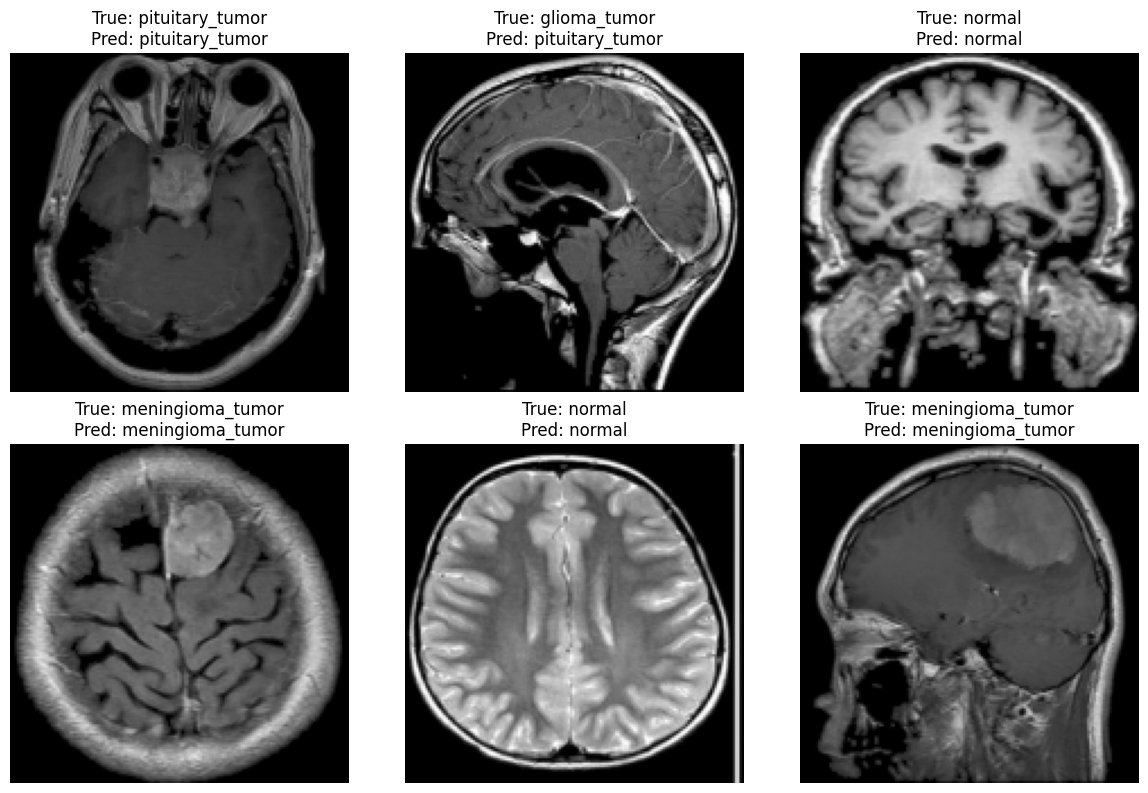

In [ ]:
import matplotlib.pyplot as plt

for images, labels in val_ds.take(1):
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    true_classes = labels.numpy()

    plt.figure(figsize=(12, 8))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[true_classes[i]]}\nPred: {class_names[predicted_classes[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break

**3. Key observations on the modal**

The base model is performing very well already without any overfitting techniques. The accuracy of the base model is above 85%, nearing close to 90%. It has an accuracy of 88%.

Also, the F1 score for most of the classes is above 85%. However, the model seems to be confused upon distinguishing meningioma and giloma maybe because of limited amount of data or likely features between two classes.

Even though the accuracy is satisfying, the model is undenibly overfitting. It might be due to the samll amount of images in the dataset.

Handing overfitting with various techniques might help to balance the model.

## **1.4 Experimentation and Comparative Analysis:**

### **1.4.1. Baseline vs. Deeper Model Performance:**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Initialize lists to store true and predicted labels
y_true = []
y_pred_baseline = []
y_pred_model = []

class_names = val_ds.class_names

# Iterate through validation dataset
for images, labels in val_ds:
    # Baseline model predictions
    preds_baseline = baseline_model.predict(images)
    y_pred_baseline.extend(np.argmax(preds_baseline, axis=1))

    # New model predictions
    preds_model = model.predict(images)
    y_pred_model.extend(np.argmax(preds_model, axis=1))

    # True labels (same for both)
    y_true.extend(labels.numpy())

# Classification reports
print("=== Baseline Model ===")
print(classification_report(y_true, y_pred_baseline, target_names=class_names))

print("\n=== New Model ===")
print(classification_report(y_true, y_pred_model, target_names=class_names))

# Confusion matrices (optional)
print("\n=== Baseline Confusion Matrix ===")
print(confusion_matrix(y_true, y_pred_baseline))

print("\n=== New Model Confusion Matrix ===")
print(confusion_matrix(y_true, y_pred_model))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
=== Baseline Model ===
                  precision    recall  f1-score   support

    glioma_tumor       0.89      0.42      0.57        81
meningioma_tumor       0.54      0.90      0.67        63
          normal       0.88      0.79      0.83        38
 pituitary_tumor       0.80      0.85      0.83        62

        accuracy                           0.71       244
       macro avg   

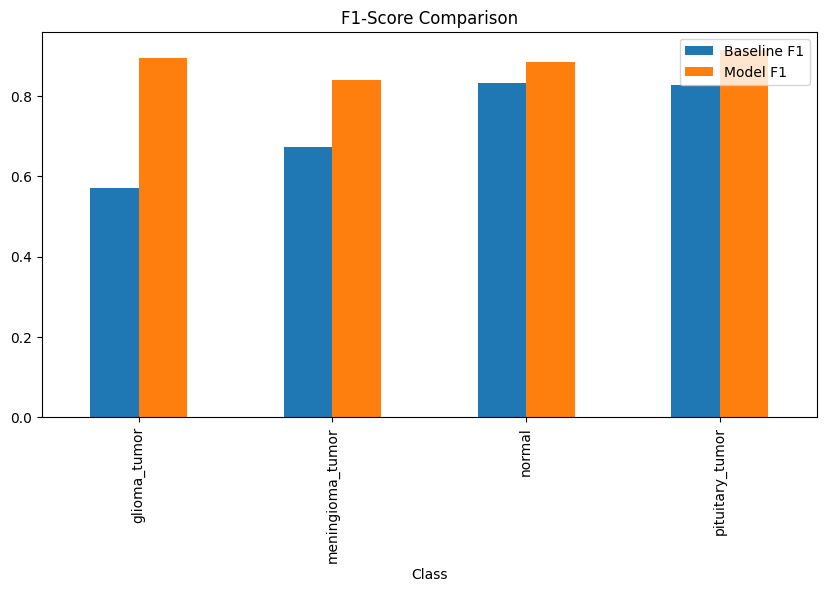

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract metrics (example for F1-scores)
report_baseline = classification_report(y_true, y_pred_baseline, target_names=class_names, output_dict=True)
report_model = classification_report(y_true, y_pred_model, target_names=class_names, output_dict=True)

df = pd.DataFrame({
    'Class': class_names,
    'Baseline F1': [report_baseline[c]['f1-score'] for c in class_names],
    'Model F1': [report_model[c]['f1-score'] for c in class_names]
})

df.plot(x='Class', y=['Baseline F1', 'Model F1'], kind='bar', figsize=(10, 5))
plt.title("F1-Score Comparison")
plt.show()

### **1.4.2. Computational Efficiency:**

**1. Compare training time between two modals**

In [ ]:
print(f"Baseline Model Training Time: {baseline_training_time:.2f} seconds")
print(f"Normal Model Training Time: {deeper_training_time:.2f} seconds")

Baseline Model Training Time: 44.31 seconds
Normal Model Training Time: 438.70 seconds


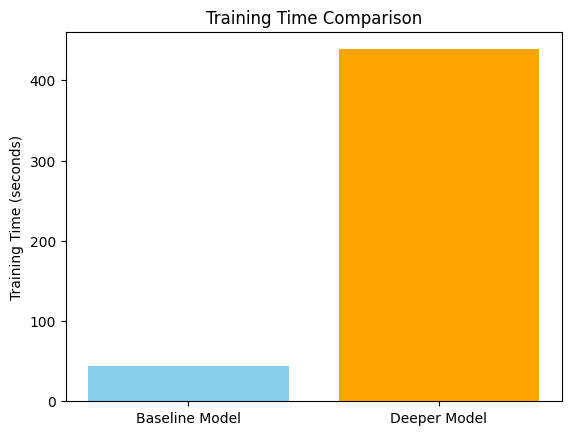

In [ ]:
import time
import matplotlib.pyplot as plt

models = ['Baseline Model', 'Deeper Model']
times = [baseline_training_time, deeper_training_time]

plt.bar(models, times, color=['skyblue', 'orange'])
plt.ylabel('Training Time (seconds)')
plt.title('Training Time Comparison')
plt.show()


**2. Compare computational cost between two modals**

In [ ]:
print(f"Baseline Training Time: {baseline_training_time:.2f}s, Memory Usage: {baseline_memory}%")
print(f"Deeper Model Training Time: {deeper_training_time:.2f}s, Memory Usage: {deeper_memory}%")

Baseline Training Time: 44.31s, Memory Usage: 59.6%
Deeper Model Training Time: 438.70s, Memory Usage: 61.5%


### **1.4.3. Optimizer Analysis: SGD vs Adam:**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

weight_decay = 1e-4  # L2 regularization factor

model_sgd = Sequential()

# Block 1
model_sgd.add(Conv2D(16, (3, 3), activation='relu', padding='same',
                 kernel_regularizer=l2(weight_decay), input_shape=(150, 150, 3)))
model_sgd.add(BatchNormalization())
model_sgd.add(MaxPooling2D((3,3)))
model_sgd.add(Dropout(0.2))

# Block 2
model_sgd.add(Conv2D(32, (3, 3), activation='relu', padding='same',
                 kernel_regularizer=l2(weight_decay)))
model_sgd.add(BatchNormalization())
model_sgd.add(MaxPooling2D((3,3)))
model_sgd.add(Dropout(0.2))

# Block 3
model_sgd.add(Conv2D(64, (3, 3), activation='relu', padding='same',
                 kernel_regularizer=l2(weight_decay)))
model_sgd.add(BatchNormalization())
model_sgd.add(MaxPooling2D((3,3)))
model_sgd.add(Dropout(0.2))

# Flatten and Dense
model_sgd.add(Flatten())
model_sgd.add(Dense(64, activation='relu', kernel_regularizer=l2(weight_decay)))
model_sgd.add(BatchNormalization())
model_sgd.add(Dropout(0.3))
model_sgd.add(Dense(32, activation='relu', kernel_regularizer=l2(weight_decay)))
model_sgd.add(BatchNormalization())
model_sgd.add(Dropout(0.3))
model_sgd.add(Dense(16, activation='relu', kernel_regularizer=l2(weight_decay)))
model_sgd.add(BatchNormalization())
model_sgd.add(Dropout(0.3))
model_sgd.add(Dense(4, activation='softmax'))  # 4 classes


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.optimizers import SGD
model_sgd.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
import matplotlib.pyplot as plt

epochs = 150

# Training the model
sgd_history = model_sgd.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[early_stopping,checkpoint],
)

Epoch 1/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.2474 - loss: 1.9032
Epoch 1: val_loss did not improve from 0.43691
69/69 ━━━━━━━━━━━━━━━━━━━━ 21s 172ms/step - accuracy: 0.2473 - loss: 1.9032 - val_accuracy: 0.2213 - val_loss: 1.4528
Epoch 2/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2641 - loss: 1.8704
Epoch 2: val_loss did not improve from 0.43691
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.2640 - loss: 1.8693 - val_accuracy: 0.2623 - val_loss: 1.4659
Epoch 3/150
68/69 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2465 - loss: 1.8661
Epoch 3: val_loss did not improve from 0.43691
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.2463 - loss: 1.8667 - val_accuracy: 0.2582 - val_loss: 1.4855
Epoch 4/150
67/69 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2571 - loss: 1.8563
Epoch 4: val_loss did not improve from 0.43691
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.2573 - loss: 1.8563 - val_accuracy: 0.2459 - val_loss: 1.5020
E

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = []
y_pred = []

class_names = test_ds.class_names

for images, labels in test_ds:
    preds = model_sgd.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix (optional but useful)
print("Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       0.57      0.68      0.62        81
meningioma_tumor       0.55      0.25      0.35        63
          normal       0.51      0.50      0.51        38
 pituitary_tumor       0.56      0.73      0.63        62

        accuracy                           0.55       244
       macro avg       0.55      0.54      0.53       244
    weighted avg       0.55      0.55      0.53       244

Confusion Matrix:

[[55  5  9 12]
 [20 16  9 18]
 [ 7  6 19  6]
 [15  2  0 45]]


# 2. Part B: Fine-Tuning a Pre-Trained Model (Transfer Learning).

## **2.1 Loading and Adapting a Pre - Trained Model:**

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

effnet = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

In [ ]:
# Unfreeze some top layers of EfficientNet
for layer in effnet.layers[-10:]:
    layer.trainable = True

In [ ]:
import tensorflow as tf # Import tensorflow as tf

pretrained_model = effnet.output
pretrained_model = tf.keras.layers.GlobalAveragePooling2D()(pretrained_model)
pretrained_model = tf.keras.layers.Dropout(rate=0.5)(pretrained_model)
pretrained_model = tf.keras.layers.BatchNormalization()(pretrained_model)
pretrained_model = tf.keras.layers.Dense(4,activation='softmax')(pretrained_model)
pretrained_model = tf.keras.models.Model(inputs=effnet.input, outputs = pretrained_model)

In [ ]:
pretrained_model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_8         │ (None, 150, 150,  │          0 │ input_layer_5[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_4     │ (None, 150, 150,  │          7 │ rescaling_8[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_9         │ (None, 150, 150,  │          0 │ normalization_4[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 151, 151,  │          0 │ rescaling_9[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 75, 75,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 75, 75,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 75, 75,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 75, 75,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │        512 │ block1a_se_excit

 Total params: 4,059,815 (15.49 MB)

 Trainable params: 4,015,232 (15.32 MB)

 Non-trainable params: 44,583 (174.16 KB)

## **2.2 Model Training and Fine - Tuning:**

In [ ]:
from tensorflow.keras.optimizers import Adam
pretrained_model.compile(loss='sparse_categorical_crossentropy',optimizer = Adam(learning_rate=0.0001), metrics= ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # Import ModelCheckpoint
import tensorflow as tf

checkpoint = ModelCheckpoint("effnet.h5",
                             monitor="val_loss",
                             save_best_only=True,
                             mode="min",
                             verbose=1)

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss",patience=5, restore_best_weights=True)

In [ ]:
pretrained_model_history = pretrained_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    verbose=1,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.4476 - loss: 1.3880
Epoch 1: val_loss improved from inf to 0.80248, saving model to effnet.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 134s 816ms/step - accuracy: 0.4495 - loss: 1.3839 - val_accuracy: 0.6885 - val_loss: 0.8025
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7770 - loss: 0.5657
Epoch 2: val_loss improved from 0.80248 to 0.62946, saving model to effnet.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.7774 - loss: 0.5648 - val_accuracy: 0.7705 - val_loss: 0.6295
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8634 - loss: 0.3778
Epoch 3: val_loss did not improve from 0.62946
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.8636 - loss: 0.3771 - val_accuracy: 0.7828 - val_loss: 0.6461
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9244 - loss: 0.2275
Epoch 4: val_loss did not improve from 0.62946
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9243 - loss: 0.2276 - val_accuracy: 0.7828 - val_loss: 0.6745
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9390 - loss: 0.1819
Epoch 5: val_loss improved from 0.62946 to 0.58787, saving model to effnet.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.9390 - loss: 0.1820 - val_accuracy: 0.8156 - val_loss: 0.5879
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9504 - loss: 0.1377
Epoch 6: val_loss improved from 0.58787 to 0.56434, saving model to effnet.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.9505 - loss: 0.1375 - val_accuracy: 0.8115 - val_loss: 0.5643
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9615 - loss: 0.1062
Epoch 7: val_loss improved from 0.56434 to 0.51177, saving model to effnet.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.9615 - loss: 0.1061 - val_accuracy: 0.8443 - val_loss: 0.5118
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9767 - loss: 0.0716
Epoch 8: val_loss improved from 0.51177 to 0.45197, saving model to effnet.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.9767 - loss: 0.0715 - val_accuracy: 0.8648 - val_loss: 0.4520
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9777 - loss: 0.0675
Epoch 9: val_loss improved from 0.45197 to 0.42594, saving model to effnet.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.9777 - loss: 0.0675 - val_accuracy: 0.8689 - val_loss: 0.4259
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9812 - loss: 0.0633
Epoch 10: val_loss improved from 0.42594 to 0.32660, saving model to effnet.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.9812 - loss: 0.0633 - val_accuracy: 0.8893 - val_loss: 0.3266
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9867 - loss: 0.0433
Epoch 11: val_loss improved from 0.32660 to 0.28236, saving model to effnet.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.9867 - loss: 0.0434 - val_accuracy: 0.9139 - val_loss: 0.2824
Epoch 12/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9788 - loss: 0.0496
Epoch 12: val_loss did not improve from 0.28236
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.9789 - loss: 0.0496 - val_accuracy: 0.9098 - val_loss: 0.3080
Epoch 13/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9878 - loss: 0.0383
Epoch 13: val_loss did not improve from 0.28236
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.9878 - loss: 0.0384 - val_accuracy: 0.9098 - val_loss: 0.3254
Epoch 14/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9862 - loss: 0.0470
Epoch 14: val_loss did not improve from 0.28236
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.9863 - loss: 0.0469 - val_accuracy: 0.9221 - val_loss: 0.3032
Epoch 15/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9885 - loss: 0.0303
Epoch 15: val_loss did not improve from 0.28236


## **2.3 Model Evaluation and Prediction:**

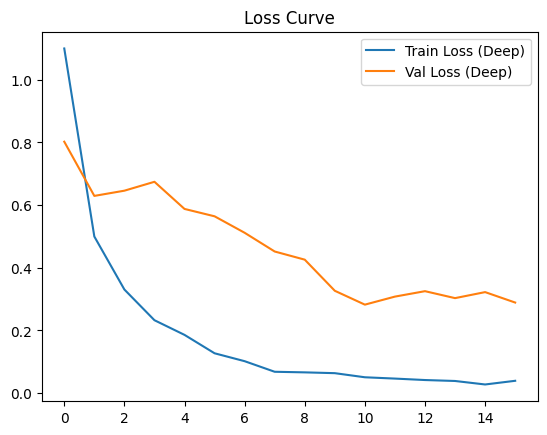

In [ ]:
# Plot loss and accuracy
plt.plot(pretrained_model_history.history['loss'], label='Train Loss (Deep)')
plt.plot(pretrained_model_history.history['val_loss'], label='Val Loss (Deep)')
# plt.plot(history_baseline.history['val_loss'], label='Val Loss (Baseline)')
plt.title('Loss Curve')
plt.legend()
plt.show()

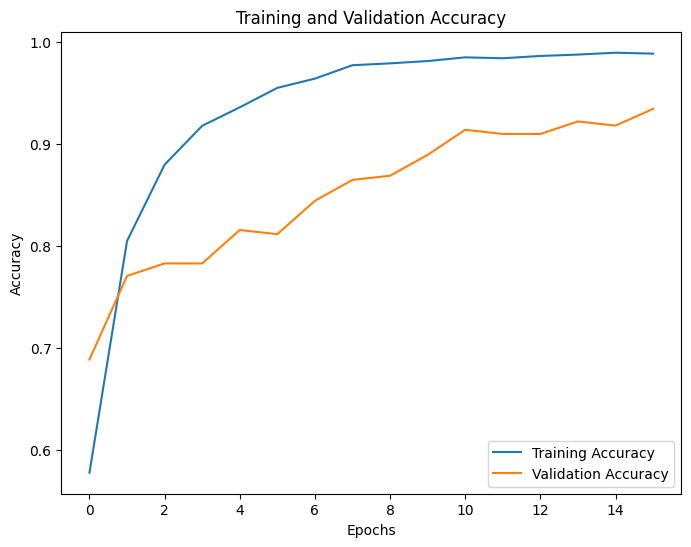

In [ ]:
trained_epochs = len(pretrained_model_history.history['loss'])

acc = pretrained_model_history.history['accuracy']
val_acc = pretrained_model_history.history['val_accuracy']

epochs_range = range(trained_epochs)

plt.figure(figsize=(8, 6))  # Adjusted size for just the accuracy plot
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

**1. Evaluate the model using appropriate metrics**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = []
y_pred = []

class_names = val_ds.class_names

for images, labels in val_ds:
    preds = pretrained_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
print("=== Pretrained Model : Validation Set ===")
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix (optional but useful)
print("Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
=== Pretrained Model : Validation Set ===
Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.88      0.93        81
meningioma_tumor       0.81      0.89      0.85        63
          normal       0.95      0.97      0.96        38
 pituitary_tumor       0.92      0.95      0.94        62

        accuracy                           0.91       244
       macro avg       0.92      0.92      0.92       244
    weighted avg       0.92      0.91      0.91       244

Confusion Matrix:

[[71 10  0  0]
 [ 0 56  2  5]
 [ 1  0 37  0]
 [ 0  3  0 59]]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = []
y_pred = []

class_names = test_ds.class_names

for images, labels in test_ds:
    preds = pretrained_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
print("=== Pretrained Model : Test Set ===")
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix (optional but useful)
print("Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
=== Pretrained Model : Test Set ===
Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.91      0.93       181
meningioma_tumor       0.89      0.93      0.91       183
       

**2. Perform inference on sample images and plot the result.**

In [ ]:
import matplotlib.pyplot as plt

for images, labels in test_ds.take(1):
    preds = pretrained_model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    true_classes = labels.numpy()

    plt.figure(figsize=(12, 8))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[true_classes[i]]}\nPred: {class_names[predicted_classes[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break

In [ ]:
# !pip uninstall jax jaxlib -y

Found existing installation: jax 0.5.2
Uninstalling jax-0.5.2:
  Successfully uninstalled jax-0.5.2
Found existing installation: jaxlib 0.5.1
Uninstalling jaxlib-0.5.1:
  Successfully uninstalled jaxlib-0.5.1


In [ ]:
# !pip install tensorflow==2.18.0